In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
images_folder = '/content/drive/MyDrive/Potato_Disease/PlantVillage'
image_files = os.listdir(images_folder)
print(image_files)

['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE =256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_folder,
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2153 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for images_batch , label_batch in dataset.take(1):
    print(images_batch[0].numpy())
    print(label_batch.numpy())

[[[111. 102. 105.]
  [114. 105. 108.]
  [106.  97. 100.]
  ...
  [155. 149. 151.]
  [152. 146. 148.]
  [151. 145. 147.]]

 [[120. 111. 114.]
  [124. 115. 118.]
  [118. 109. 112.]
  ...
  [160. 154. 156.]
  [160. 154. 156.]
  [159. 153. 155.]]

 [[119. 110. 113.]
  [123. 114. 117.]
  [117. 108. 111.]
  ...
  [161. 155. 157.]
  [162. 156. 158.]
  [162. 156. 158.]]

 ...

 [[131. 126. 132.]
  [126. 121. 127.]
  [132. 127. 133.]
  ...
  [189. 184. 188.]
  [191. 186. 190.]
  [190. 185. 189.]]

 [[126. 121. 127.]
  [121. 116. 122.]
  [129. 124. 130.]
  ...
  [195. 190. 194.]
  [193. 188. 192.]
  [187. 182. 186.]]

 [[119. 114. 120.]
  [111. 106. 112.]
  [121. 116. 122.]
  ...
  [191. 186. 190.]
  [187. 182. 186.]
  [178. 173. 177.]]]
[0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 2 1 1 2 0 2 1 1 0 1 0]


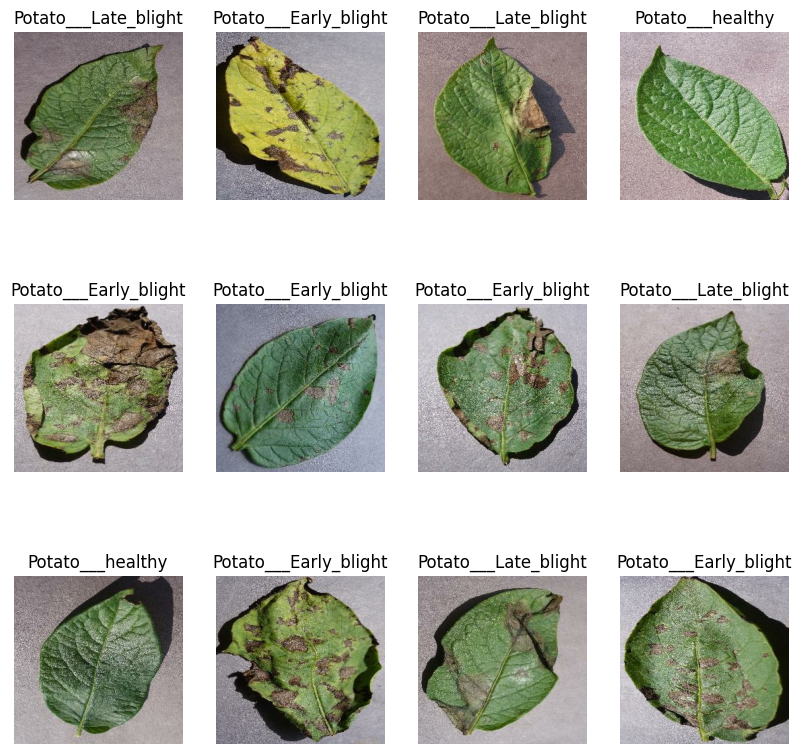

In [ ]:
plt.figure(figsize=(10,10))
for images_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
#splitting dataset
#80% test
#20% 10% validation 10% test for accuracy before deploying the model
training_size = 0.8
len(dataset)*training_size

54.400000000000006

In [ ]:
train_DS = dataset.take(54)
len(train_DS)

54

In [ ]:
test_DS=dataset.skip(54)
len(test_DS)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_DS = test_DS.take(6)
len(val_DS)

6

In [ ]:
test_DS = test_DS.skip(6)

In [ ]:
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split *ds_size)
    val_size =int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds



In [ ]:
train_ds,val_ds,test_ds = get_dataset_partition(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds .cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
#building model
n_classes=3
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), batch_size=BATCH_SIZE),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 18s 184ms/step - loss: 1.3683 - accuracy: 0.5914 - val_loss: 0.6723 - val_accuracy: 0.6354
Epoch 2/50
54/54 [==============================] - 3s 58ms/step - loss: 0.4199 - accuracy: 0.8351 - val_loss: 0.5804 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2700 - accuracy: 0.8993 - val_loss: 0.2142 - val_accuracy: 0.9271
Epoch 4/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2622 - accuracy: 0.8935 - val_loss: 0.5417 - val_accuracy: 0.7135
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2018 - accuracy: 0.9196 - val_loss: 0.1930 - val_accuracy: 0.9427
Epoch 6/50
54/54 [==============================] - 3s 62ms/step - loss: 0.1808 - accuracy: 0.9282 - val_loss: 0.2256 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 3s 58ms/step - loss: 0.1851 - accuracy: 0.9329 - val_loss: 0.5848 - val_accuracy: 0.7969
Epoch 8/50


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 27ms/step - loss: 0.0445 - accuracy: 0.9805


In [ ]:
scores

[0.044460467994213104, 0.98046875]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.5914351940155029,
 0.8350694179534912,
 0.8993055820465088,
 0.8935185074806213,
 0.9195601940155029,
 0.9282407164573669,
 0.9328703880310059,
 0.9270833134651184,
 0.9253472089767456,
 0.9438657164573669,
 0.9513888955116272,
 0.9722222089767456,
 0.9618055820465088,
 0.9508101940155029,
 0.9577546119689941,
 0.9733796119689941,
 0.9664351940155029,
 0.9739583134651184,
 0.9751157164573669,
 0.9803240895271301,
 0.9461805820465088,
 0.9704861044883728,
 0.9733796119689941,
 0.9809027910232544,
 0.9739583134651184,
 0.9814814925193787,
 0.9791666865348816,
 0.9814814925193787,
 0.9826388955116272,
 0.96875,
 0.9710648059844971,
 0.9826388955116272,
 0.9733796119689941,
 0.9762731194496155,
 0.9895833134651184,
 0.9814814925193787,
 0.9629629850387573,
 0.9664351940155029,
 0.9699074029922485,
 0.9623842835426331,
 0.9895833134651184,
 0.9809027910232544,
 0.9803240895271301,
 0.9791666865348816,
 0.9890046119689941,
 0.9890046119689941,
 0.9872685074806213,
 0.9751157164573669,
 0.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

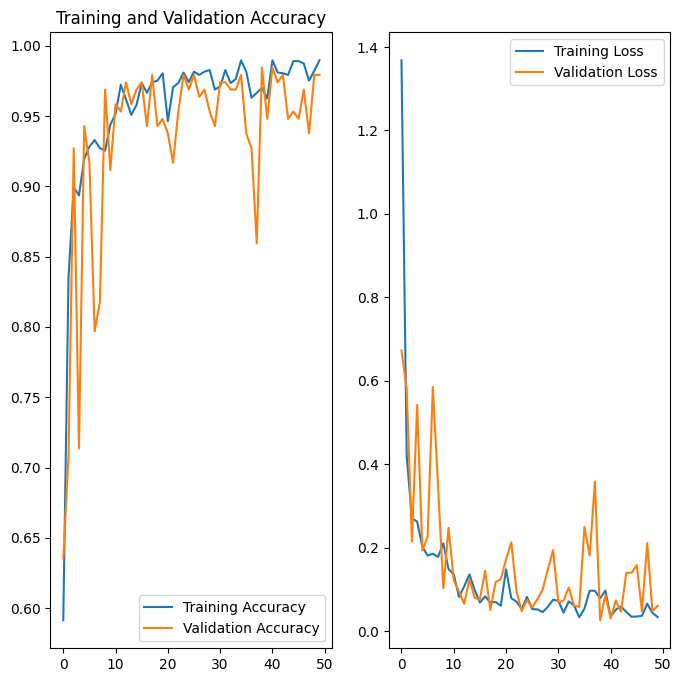

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 173ms/step
predicted_lable :  Potato___Late_blight


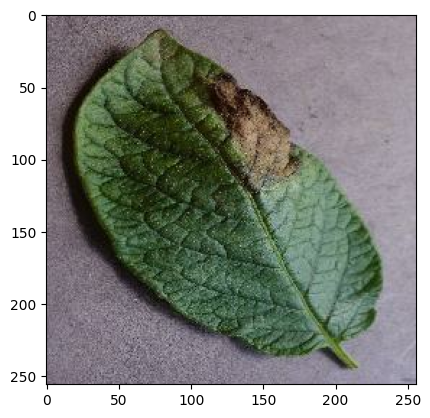

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction =model.predict(images_batch)
  print("predicted_lable : ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


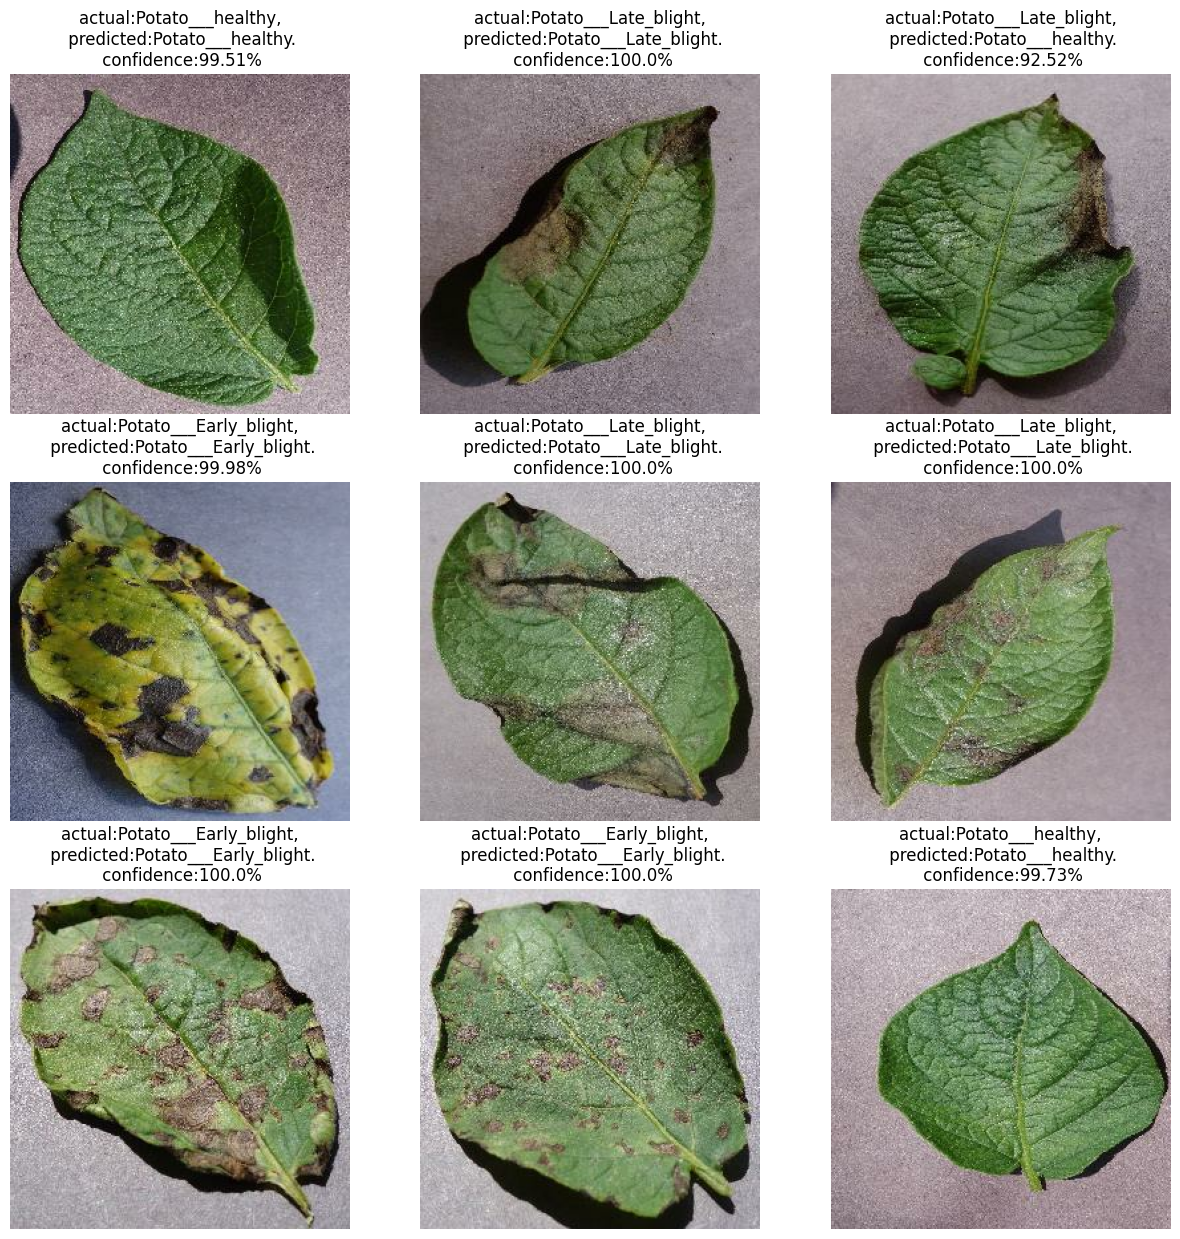

In [ ]:
plt.figure(figsize=(15,15))
for images , lables in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[lables[i]]
    plt.title(f"actual:{actual_class},\n predicted:{predicted_class}.\n confidence:{confidence}%")

In [ ]:
model_version=1
model.save(f"/content/drive/MyDrive/Potato_Disease/models/{model_version}")